# The following notebook does the fllowing operations:
* Reads the 2mm brainetome atlas file in standard MNI152 space
* Reads the thresholded 2mm Tvalues files created in previous step - Negative and positive t values
* Iterates over each of them and calculate the following for each ROI:
    * Number of voxels
    * Number of voxels > 0 in Negative t values file (Absolute)
    * Number of voxels > 0 in Positive t values file
    


In [1]:
# Read the atlas
import nibabel as nib
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import os

In [2]:
# Read Brainnetome atlas
atlas_path = 'BNA-maxprob-thr0-2mm.nii.gz'
atlas = nib.load(atlas_path).get_data()

In [3]:
np.min(atlas), np.max(atlas)

(0.0, 246.0)

In [4]:
if not os.path.exists('negClusterStats.npy'):
    # Loop over the two brains to compute the ROI wise t value stats

    # Read the two brains
    absNegTvalsBrainPath = 'tValNegThrAbs.nii.gz' 
    posTvalsBrainPath = 'tValPosThr.nii.gz'

    numVoxelsPerRoi = []
    numPosVoxelsPerRoi = []
    numNegVoxelsPerRoi = []

    negClusterStats = np.zeros((int(np.max(atlas)), int(np.max(atlas)) ))
    posClusterStats = np.zeros((int(np.max(atlas)), int(np.max(atlas)) ))


    absNegTvalsBrain = nib.load(absNegTvalsBrainPath).get_data()
    posTvalsBrain = nib.load(posTvalsBrainPath).get_data()

    # Need to work more on Vol_ROI and roi both they are wrong.

    for vol_roi in tqdm(range(int(np.max(atlas)))):
        numVoxelsPerRoi.append(len(np.where(atlas == vol_roi + 1)[0]))
    #     print(vol_roi)
        for roi in range(int(np.max(atlas))):
            temp = posTvalsBrain[:,:,:,vol_roi][np.where(atlas == roi + 1)]
            posClusterStats[vol_roi,roi] = len(np.where(temp > 0 )[0])

            temp = absNegTvalsBrain[:,:,:,vol_roi][np.where(atlas == roi + 1)]
            negClusterStats[vol_roi,roi] = len(np.where(temp > 0 )[0])


    print('Saving the calculated Arrays')
    np.save('numVoxelsPerRoi',numVoxelsPerRoi)
    np.save('negClusterStats',negClusterStats)
    np.save('posClusterStats',posClusterStats)

else:
    print('Loaded stats files')
    numVoxelsPerRoi = np.load('numVoxelsPerRoi.npy')
    negClusterStats = np.load('negClusterStats.npy')
    posClusterStats = np.load('posClusterStats.npy')




Loaded stats files


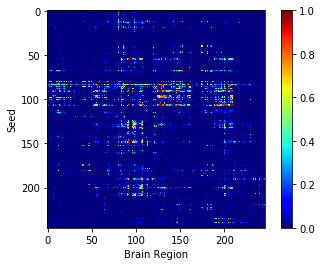

In [12]:
ClusterStats = negClusterStats
# ClusterStats = posClusterStats

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.divide(ClusterStats,numVoxelsPerRoi), cmap=plt.cm.jet, 
                interpolation='nearest')

cb = fig.colorbar(res)
plt.ylabel('Seed')
plt.xlabel('Brain Region')
plt.savefig("roiXroi_orig_hypo.png", format="png")


In [13]:
# Finding the density of correlations

# negClusterStats.shape
numVoxelsPerRoi = np.array(numVoxelsPerRoi).reshape(1,len(numVoxelsPerRoi))
numVoxelsPerRoi.shape

(1, 246)

In [10]:
negClusterStats[:,100]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        13.,  73.,  69., 125.,  38.,   0.,   0.,  56., 165.,   0.,  20.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  21.,  11.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  53.,  68.,
        85.,  12.,  82.,   0.,  77.,   0.,   0.,   0.,   0.,  83., 158.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,  15.,   0.,   0.,   0., 225.,  38.,  29.,   0.,
         0.,   0.,   0.,   9.,   0.,   0.,   0.,   0.,   5.,   0.,  16.,
         0.,   0.,   0.,   0.,   0.,  28.,  22.,   0.,   5.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   2.,   0.,   0.,   8.,  33.,  39., 154., 148.,   8.,  27.,
        62.,   6.,   0.,   0.,   0.,   0.,   5.,   5.,  53.,   3.,   1.,
         0.,   0.,   0.,  31.,  49., 228., 173.,   

In [ ]:
# 208/0.231, 37/0.05, 13/0.02229846, 73/0.12521441

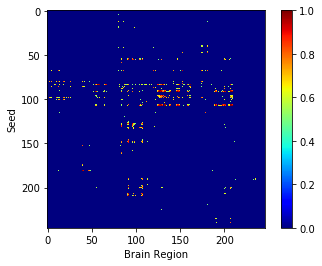

In [30]:
negClusterStatsDensity = np.divide(negClusterStats,numVoxelsPerRoi)
# posClusterStatsDensity = np.divide(posClusterStats,numVoxelsPerRoi)

ClusterStatsDensity = negClusterStatsDensity

ClusterStatsDensityThreshZero = ClusterStatsDensity < 0.5
ClusterStatsDensityThreshOne = ClusterStatsDensity >= 0.5

ClusterStatsDensity[ClusterStatsDensityThreshZero] = 0


fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(ClusterStatsDensity, cmap=plt.cm.jet, 
                interpolation='nearest')

plt.xlabel('Brain Region')
plt.ylabel('Seed')

cb = fig.colorbar(res)
plt.savefig("roiXroi_thresholded50percent.png", format="png")



In [31]:
np.savetxt('negClusterStatsDensity.csv',negClusterStatsDensity,fmt='%3.5f',delimiter=',')

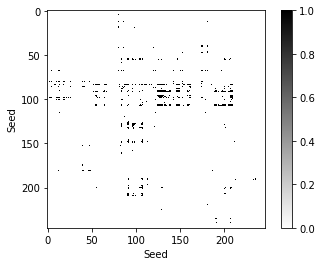

In [33]:
# Binarize

ClusterStatsDensity[ClusterStatsDensityThreshOne] = 1


fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(ClusterStatsDensity, cmap=plt.cm.binary, 
                interpolation='nearest')

cb = fig.colorbar(res)
plt.xlabel('Seed')
plt.ylabel('Seed')
plt.savefig("roiXroi_binarize.png", format="png")




In [34]:
negClusterStatsDensity = ClusterStatsDensity
np.savetxt('negClusterStatsDensityBinary.csv',negClusterStatsDensity,fmt='%3.5f',delimiter=',')

In [35]:
hypoConnInfo = []
for vol_roi in range(negClusterStatsDensity.shape[0]):
    idx = np.where(negClusterStatsDensity[vol_roi,:] == 1)[0]
    if len(idx) > 0:
        hypoConnInfo.append([vol_roi+1, idx+1])
    
    
    

In [36]:
hypoConnInfo

[[6, array([81])],
 [13, array([ 81,  84,  87, 182])],
 [14, array([ 81,  84,  87, 114, 143, 153, 154, 175, 176, 181, 182])],
 [19, array([81])],
 [20, array([81, 99])],
 [41, array([175, 176, 182])],
 [42, array([175, 176, 182])],
 [43, array([ 81,  87, 121])],
 [47, array([182])],
 [48, array([153, 154, 175, 176, 181, 182])],
 [55, array([ 85,  91,  92,  97, 105, 106, 108, 128, 148, 201, 208])],
 [56, array([ 85,  91,  92,  97,  98, 100, 105, 106, 108, 126, 128, 130, 148,
         189, 201, 202, 206])],
 [58, array([ 85, 201])],
 [60, array([85])],
 [66, array([85, 92])],
 [69, array([  6,  13,  14,  15,  75,  81,  85,  87, 121, 123, 143, 151, 153,
         154, 175, 176, 179, 181, 182, 197, 198])],
 [81, array([  3,   5,   6,  11,  13,  14,  15,  19,  20,  27,  41,  43,  48,
         143, 153, 154, 175, 176])],
 [83, array([143, 153, 175, 181])],
 [84, array([  6,  13,  14,  87, 121, 123, 143, 144, 147, 151, 153, 154, 175,
         176, 181, 182, 185, 186])],
 [85, array([  9,  10, 

In [37]:
atlasRegionsDescrpPath = '/home/varun/Projects/fmri/Autism-Connectome-Analysis-brain_connectivity/atlas/BNA_subregions.xlsx'
df = pd.read_excel(atlasRegionsDescrpPath)
df

,Lobe,Gyrus,Left and Right Hemisphere,Label ID.L,Label ID.R,Unnamed: 5,Anatomical and modified Cyto-architectonic descriptions,"lh.MNI(X,Y,Z)","rh.MNI(X,Y,Z)"
0,Frontal Lobe,"SFG, Superior Frontal Gyrus",SFG_L(R)_7_1,1,2,"A8m, medial area 8",NaN,"-5 ,15, 54","7, 16, 54"
1,NaN,NaN,SFG_L(R)_7_2,3,4,"A8dl, dorsolateral area 8",NaN,"-18, 24, 53","22, 26, 51"
2,NaN,NaN,SFG_L(R)_7_3,5,6,"A9l, lateral area 9",NaN,"-11, 49, 40","13, 48, 40"
3,NaN,NaN,SFG_L(R)_7_4,7,8,"A6dl, dorsolateral area 6",NaN,"-18, -1, 65","20, 4, 64"
4,NaN,NaN,SFG_L(R)_7_5,9,10,"A6m, medial area 6",NaN,"-6, -5, 58","7, -4, 60"
5,NaN,NaN,SFG_L(R)_7_6,11,12,"A9m,medial area 9",NaN,"-5, 36, 38","6, 38, 35"
6,NaN,NaN,SFG_L(R)_7_7,13,14,"A10m, medial area 10",NaN,"-8, 56, 15","8, 58, 13"
7,NaN,"MFG, Middle Frontal Gyrus",MFG_L(R)_7_1,15,16,"A9/46d, dorsal area 9/46",NaN,"-27, 43, 31","30, 37, 36"
8,NaN,NaN,MFG_L(R)_7_2,17,18,"IFJ, inferior frontal junction",NaN,"-42, 13, 36","42, 11, 39"
9,NaN,NaN,MFG_L(R)_7_3,19,20,"A46, area 46",NaN,"-28, 56, 12","28, 55, 17"


In [38]:
df = df.as_matrix(['Label ID.L', 'Label ID.R','Left and Right Hemisphere','Unnamed: 5', 'lh.MNI(X,Y,Z)', 'rh.MNI(X,Y,Z)'])
df

array([[1, 2, 'SFG_L(R)_7_1', 'A8m, medial area 8', '-5 ,15, 54 ',
        '7, 16, 54 '],
       [3, 4, 'SFG_L(R)_7_2', 'A8dl, dorsolateral area 8',
        '-18, 24, 53 ', '22, 26, 51 '],
       [5, 6, 'SFG_L(R)_7_3', 'A9l, lateral area 9', '-11, 49, 40 ',
        '13, 48, 40 '],
       [7, 8, 'SFG_L(R)_7_4', 'A6dl, dorsolateral area 6',
        '-18, -1, 65 ', '20, 4, 64 '],
       [9, 10, 'SFG_L(R)_7_5', 'A6m, medial area 6', '-6, -5, 58 ',
        '7, -4, 60 '],
       [11, 12, 'SFG_L(R)_7_6', 'A9m,medial area 9', '-5, 36, 38 ',
        '6, 38, 35 '],
       [13, 14, 'SFG_L(R)_7_7', 'A10m, medial area 10', '-8, 56, 15 ',
        '8, 58, 13 '],
       [15, 16, 'MFG_L(R)_7_1', 'A9/46d, dorsal area 9/46',
        '-27, 43, 31 ', '30, 37, 36 '],
       [17, 18, 'MFG_L(R)_7_2', 'IFJ, inferior frontal junction',
        '-42, 13, 36 ', '42, 11, 39 '],
       [19, 20, 'MFG_L(R)_7_3', 'A46, area 46', '-28, 56, 12 ',
        '28, 55, 17 '],
       [21, 22, 'MFG_L(R)_7_4', 'A9/46v, ventral a

In [39]:
numSeeds = 246
seedInfo = np.empty((numSeeds + 1, 3),dtype=object)
for i,j,region,label,lcoord,rcoord in df:
    seedInfo[i,:] = i, region.split('_')[0] + '_' + label, lcoord
    seedInfo[j,:] = j, region.split('_')[0] + '_' + label, rcoord

In [40]:
seedInfo[1:]

array([[1, 'SFG_A8m, medial area 8', '-5 ,15, 54 '],
       [2, 'SFG_A8m, medial area 8', '7, 16, 54 '],
       [3, 'SFG_A8dl, dorsolateral area 8', '-18, 24, 53 '],
       [4, 'SFG_A8dl, dorsolateral area 8', '22, 26, 51 '],
       [5, 'SFG_A9l, lateral area 9', '-11, 49, 40 '],
       [6, 'SFG_A9l, lateral area 9', '13, 48, 40 '],
       [7, 'SFG_A6dl, dorsolateral area 6', '-18, -1, 65 '],
       [8, 'SFG_A6dl, dorsolateral area 6', '20, 4, 64 '],
       [9, 'SFG_A6m, medial area 6', '-6, -5, 58 '],
       [10, 'SFG_A6m, medial area 6', '7, -4, 60 '],
       [11, 'SFG_A9m,medial area 9', '-5, 36, 38 '],
       [12, 'SFG_A9m,medial area 9', '6, 38, 35 '],
       [13, 'SFG_A10m, medial area 10', '-8, 56, 15 '],
       [14, 'SFG_A10m, medial area 10', '8, 58, 13 '],
       [15, 'MFG_A9/46d, dorsal area 9/46', '-27, 43, 31 '],
       [16, 'MFG_A9/46d, dorsal area 9/46', '30, 37, 36 '],
       [17, 'MFG_IFJ, inferior frontal junction', '-42, 13, 36 '],
       [18, 'MFG_IFJ, inferior fron

In [41]:
# Create a dictionary of seedInfo

d = {}
for i in seedInfo[1:]:
    d[i[0]] = i[1:]
    

In [58]:
d[1]

array(['SFG_A8m, medial area 8', '-5 ,15, 54 '], dtype=object)

In [43]:
def queryDict(lis):
    return_regions = []
    for i in lis:
#         return_regions.append(str(i)+"_"+d[i][0])
        return_regions.append(d[i][0])
    return return_regions
        

In [44]:
def HO_region(out):
    out_new = []
    i = 0
    for entry in out:
        if 'No label found' in entry:
            return ''
        if (i == 0) and ('Cerebral' in entry):
            return ''
        if '%' in entry:
            out_new.append(entry)
            i=i+1
        else:
            out_new[i-1] = out_new[i-1] + '_'+ entry 

    return out_new[0]     


In [45]:
def getHOAtlasRegions(coord):
    import subprocess

    p1 = subprocess.Popen(["atlasquery", "-a", "Harvard-Oxford Cortical Structural Atlas", "-c", coord ], stdout=subprocess.PIPE)
    p2 = subprocess.Popen(["atlasquery", "-a", "Harvard-Oxford Subcortical Structural Atlas", "-c", coord], stdout=subprocess.PIPE)

    out1 = p1.communicate()
    out2 = p2.communicate()

    out = []


    out1 = str(out1[0]).split('<br>')[1].split(',')
    out2 = str(out2[0]).split('<br>')[1].split(',')
    
    if int(coord.split(',')[0]) < 0:
        hemisphere = '_L'
    else:
        hemisphere = '_R'
    return [HO_region(out1) + hemisphere ,  HO_region(out2)+ hemisphere ]

    
# d = {'ROI':[roi], 'Voxels':[row[0]], 'Max_tvalue':[row[1]], 'MNI(X Y Z)':[coord], 'Harvard-Oxford Cortical Structural Atlas':[str(out1[0]).split('>')[3]], 'Harvard-Oxford Subcortical Structural Atlas':str(out2[0]).split('>')[3], 'Juelich Histological Atlas':str(out3[0]).split('>')[3]}

    
    

In [46]:
getHOAtlasRegions('28, 55, 17 ')

["81% Frontal Pole\\n'_R", '_R']

In [47]:
df_new = pd.DataFrame(columns=["seedNumber", "seedName","connections"])
for i in range(len(hypoConnInfo)):
    roi = hypoConnInfo[i][0]
    seed = d[roi][0]
    connections = queryDict(hypoConnInfo[i][1])
#     print(roi,seed,connections)
    df_new = df_new.append({
     "seedNumber": roi,
     "seedName": seed ,
     "connections": connections
      }, ignore_index=True)
    
    

In [48]:
df_new.to_csv('hypoConnSeeds_new.csv')

In [49]:
df_new

,seedNumber,seedName,connections
0,6,"SFG_A9l, lateral area 9","[MTG_A21c, caudal area 21]"
1,13,"SFG_A10m, medial area 10","[MTG_A21c, caudal area 21, MTG_A21r, rostral a..."
2,14,"SFG_A10m, medial area 10","[MTG_A21c, caudal area 21, MTG_A21r, rostral a..."
3,19,"MFG_A46, area 46","[MTG_A21c, caudal area 21]"
4,20,"MFG_A46, area 46","[MTG_A21c, caudal area 21, ITG_A20cl, caudolat..."
5,41,"OrG_A14m, medial area 14","[CG_A23d, dorsal area 23, CG_A23d, dorsal area..."
6,42,"OrG_A14m, medial area 14","[CG_A23d, dorsal area 23, CG_A23d, dorsal area..."
7,43,"OrG_A12/47o, orbital area 12/47","[MTG_A21c, caudal area 21, MTG_aSTS, anterior ..."
8,47,"OrG_A11m, medial area 11","[CG_A23v, ventral area 23]"
9,48,"OrG_A11m, medial area 11","[PCun_A31, area 31 (Lc1), PCun_A31, area 31 (L..."


## Report HO atlas regions instead of Brainnetome regions

In [50]:
def queryDict_HO(lis):
    return_cortical_regions = []
    return_subcortical_regions = []
    for i in lis:
#         print(getHOAtlasRegions(d[i][1]))
        cortical,subcortical = getHOAtlasRegions(d[i][1])
        if (cortical == '_L') or (cortical == '_R'):
            cortical = ''
        else:
            cortical = str(i)+ "_" + cortical
            
        if (subcortical == '_L') or (subcortical == '_R'):
            subcortical = ''
        else:
            subcortical = str(i)+ "_" + subcortical
            
        return_cortical_regions.append(cortical)
        return_subcortical_regions.append(subcortical)
    return return_cortical_regions+return_subcortical_regions
        

In [53]:
queryDict_HO([1])

['1_42% Superior Frontal Gyrus_L', '']

In [54]:
df_new_HO = pd.DataFrame(columns=["seedNumber", "seedName","connections","seed_HO", "connections_HO"])
for i in tqdm(range(len(hypoConnInfo))):
    roi = hypoConnInfo[i][0]
    seed = d[roi][0]
    connections = queryDict(hypoConnInfo[i][1])
    
    seed_HO = queryDict_HO([roi])
    connections_HO = queryDict_HO(hypoConnInfo[i][1])
    
#     print(roi,seed,connections,seed_HO,connections_HO)
    df_new_HO = df_new_HO.append({
     "seedNumber": roi,
     "seedName": seed ,
     "connections": connections,
     "seed_HO": seed_HO,
    "connections_HO": connections_HO
      }, ignore_index=True)
    
    

100%|██████████| 73/73 [34:33<00:00, 28.40s/it]


In [55]:
df_new_HO.to_csv('hypoConnSeeds_HO.csv')

## Checking consistency of brainnetome atlas vs HO atlas

In [62]:
df_atlas = pd.DataFrame(columns=["seedNumber", "seedNameBrainnetome","seedNameHO"])
for i in tqdm(range(1, int(np.max(atlas) + 1))):
    roi = i
    seed = d[roi][0]
#     connections = queryDict(hypoConnInfo[i][1])
    seedHO = queryDict_HO([roi])
#     print(roi,seed,connections)
    df_atlas = df_atlas.append({
     "seedNumber": roi,
     "seedNameBrainnetome": seed ,
     "seedNameHO": seedHO
      }, ignore_index=True)
    


  1%|          | 2/246 [00:05<11:54,  2.93s/it]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 246/246 [11:47<00:00,  2.88s/it]


In [ ]:
df_atlas.to_csv('atlas_brainnetome_HO.csv')

In [60]:
df_atlas

,seedNumber,seedNameBrainnetome,seedNameHO
0,6,"SFG_A9l, lateral area 9","[6_68% Frontal Pole\n'_R, ]"
1,13,"SFG_A10m, medial area 10","[13_22% Frontal Pole_L, ]"
2,14,"SFG_A10m, medial area 10","[14_51% Frontal Pole_R, ]"
3,19,"MFG_A46, area 46","[19_86% Frontal Pole\n'_L, ]"
4,20,"MFG_A46, area 46","[20_81% Frontal Pole\n'_R, ]"
5,41,"OrG_A14m, medial area 14","[41_51% Frontal Medial Cortex_L, ]"
6,42,"OrG_A14m, medial area 14","[42_57% Paracingulate Gyrus_R, ]"
7,43,"OrG_A12/47o, orbital area 12/47","[43_59% Frontal Orbital Cortex_L, ]"
8,47,"OrG_A11m, medial area 11","[47_29% Frontal Medial Cortex_L, ]"
9,48,"OrG_A11m, medial area 11","[48_45% Frontal Pole_R, ]"


## Takeaway
Be careful while using 2 atlases. ROI 41 and 42 are left and right regions of the same ROI. But HO atlas tell them to be different. This means that brainnetome atlas is not symmetric across the medial line.

# Dump

In [ ]:
f = open('filr=log.txt',mode='a+')

In [ ]:
text =  'Computing stats for ROI: ' + str(roi_vol) + '\n'
f.write()

In [26]:
temp1 = np.array([[1,2],[3,4]])
temp2 = np.array([1,2]).reshape(1,2)                  

In [27]:
temp1,temp2

(array([[1, 2],
        [3, 4]]), array([[1, 2]]))

In [28]:
np.divide(temp1,temp2)

array([[1., 1.],
       [3., 2.]])

In [29]:
temp2.shape

(1, 2)